# Correlation among in the Upwelling Indices

#### Correlation (between UI<sub>Ek</sub>, UI<sub>SST</sub> and UI<sub>SSH</sub>)
1. Weekly correlation
    - whole period
    - whole period with delay
2. Annual correlation
    - annual mean correlation
    - seasonal summer mean correlation

## Import packages and data

In [6]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.dates as dates
import matplotlib
#import cartopy.crs as ccrs
import os
import my_functions
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
UI_SST = xr.open_dataset('UI_SST.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

## Data Prep

In [8]:
## selct common period MTSS and SST
MTSS = MTSS.sel(time = slice('01/01/1982', '31/12/2022'))
SST = SST.sel(time = slice('01/01/1982', '31/12/2022'))

In [9]:
## calculate the UIs (and add mid_shelf mask)
# UI Ek
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm))
Ek = my_functions.add_mid_shelf(Ek, mid_shelf_lat, mid_shelf_lon)

# UI SST and SSH
SST = my_functions.add_mid_shelf(SST, mid_shelf_lat, mid_shelf_lon)
SST['UI'] = SST.SST.where(SST.lon == -15.019103) - SST.SST.where(SST.mid_shelf).mean(dim = 'lon')
SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [10]:
## meridional mean
Ek = my_functions.calc_meridional_mean(Ek, lon = -10.5)
SST = my_functions.calc_meridional_mean(SST, lon = -15.019103)
UI_SST = my_functions.calc_meridional_mean(UI_SST, lon = -15)
SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)

In [11]:
## summer subset
Ek_summer = my_functions.subset_summer(Ek)
SST_summer = my_functions.subset_summer(SST)
UI_SST_summer = my_functions.subset_summer(UI_SST)
SSH_summer = my_functions.subset_summer(SSH)

## Meridional Mean Correlation

In [12]:
pearsonr(Ek.UI_mean, SST.UI_mean)

PearsonRResult(statistic=0.2163831321576734, pvalue=4.418953343345083e-24)

In [13]:
pearsonr(Ek_summer.UI_mean, SST_summer.UI_mean)

PearsonRResult(statistic=0.19409178475474784, pvalue=1.0700493484858693e-07)

## Meridional Mean, Annual Correlation

In [24]:
Ek_annual = Ek.resample(time = 'YE').mean(dim = 'time')
Ek_summer_annual = Ek_summer.resample(time = 'YE').mean(dim = 'time')
SST_annual = SST.resample(time = 'YE').mean(dim = 'time')
SST_summer_annual = SST_summer.resample(time = 'YE').mean(dim = 'time')
SSH_annual = SSH.resample(time = 'YE').mean(dim = 'time')
SSH_summer_annual = SSH_summer.resample(time = 'YE').mean(dim = 'time')

In [29]:
pearsonr(Ek_annual.UI_mean, SST_annual.UI_mean)

PearsonRResult(statistic=0.48876363024384756, pvalue=0.0011849851565796149)

In [35]:
x = (Ek_annual.UI_mean - Ek_annual.UI_mean.mean())/Ek_annual.UI_mean.std()
y = (SST_annual.UI_mean - SST_annual.UI_mean.mean())/SST_annual.UI_mean.std()
pearsonr(x, y)

PearsonRResult(statistic=0.48876363024384756, pvalue=0.0011849851565796149)

In [25]:
pearsonr(Ek_summer_annual.UI_mean, SST_summer_annual.UI_mean)

PearsonRResult(statistic=0.43011844968901586, pvalue=0.00500306402437815)

(array([4., 3., 0., 9., 8., 7., 4., 3., 1., 2.]),
 array([-2.05089923, -1.61278087, -1.17466251, -0.73654415, -0.29842579,
         0.13969257,  0.57781094,  1.0159293 ,  1.45404766,  1.89216602,
         2.33028438]),
 <BarContainer object of 10 artists>)

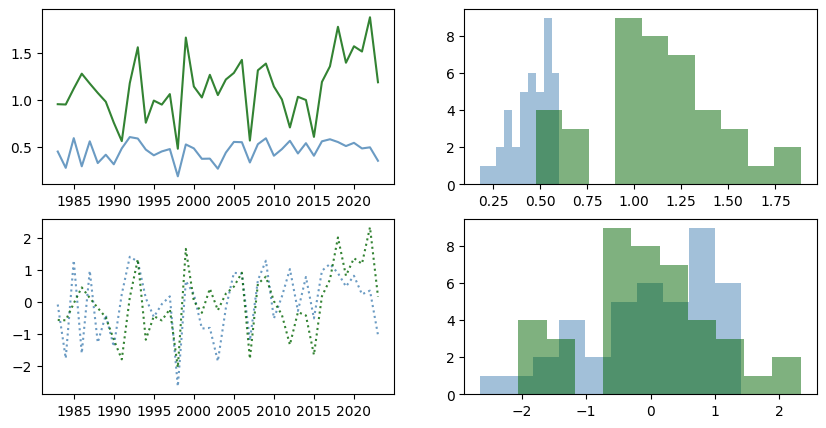

In [50]:
figure, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, figsize = (10, 5))
ax1.plot(Ek_annual.time, Ek_annual.UI_mean, color = 'steelblue', alpha = 0.8)
ax1.plot(SST_annual.time, SST_annual.UI_mean, color = 'darkgreen', alpha = 0.8)
ax2.hist(Ek_annual.UI_mean, color = 'steelblue', alpha = 0.5)
ax2.hist(SST_annual.UI_mean, color = 'darkgreen', alpha = 0.5)

ax3.plot(Ek_annual.time, x, color = 'steelblue', alpha = 0.8, linestyle = ':')
ax3.plot(SST_annual.time, y, color = 'darkgreen', alpha = 0.8, linestyle = ':')
ax4.hist(x, color = 'steelblue', alpha = 0.5)
ax4.hist(y, color = 'darkgreen', alpha = 0.5)

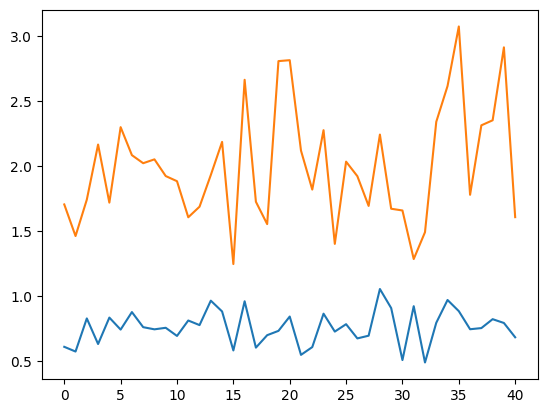

In [27]:
plt.plot(Ek_summer_annual.UI_mean)
plt.plot(SST_summer_annual.UI_mean)